<div class="alert alert-block alert-info">
<b>PILOT</b>

Welcome to the PILOT Package Tutorial for scRNA and pathomics Data!

The PILOT (PatIent-Level distances from single-cell genomics and pathomics data with Optimal Transport) package is a powerful toolkit designed to analyze single-cell RNA sequencing (scRNAseq) and pathomics data (extracted morphological features from pathological images). This tutorial will guide you through the functionalities and workflows of the PILOT package, enabling you to leverage its capabilities for comprehensive analysis and interpretation of your complex data.

With PILOT, you can efficiently explore omics and pathomics data, which provides insights into cellular and molecular/structural changes over disease progression. This breakdown allows for a deeper understanding of disease trajectories, leading to valuable discoveries and novel biological insights.

Throughout this tutorial, we will cover the basic usage of the PILOT package, including loading and preprocessing scRNAseq and pathomics data for uncovering trajectories of diseases and also changes over them. We will also explore visualization techniques to gain visual insights into the data.

By the end of this tutorial, you will have a solid foundation in using the PILOT package to unlock the potential of scRNAseq and pathomics data, empowering you to unravel complex biological processes with detail. 
Let's embark on this exciting journey!

Here we show the whole process for applying PILOT to scRNA data using Myocardial infarction data, you can download if from [here](https://costalab.ukaachen.de/open_data/PILOT/myocardial_infarction.h5ad).

</div>

In [1]:
# Import PILOT functionalities
from PILOT import *

### Reading Anndata
 * Using "extract_data_anno_scRNA_from_h5ad" function, first you need to load the object.

In [2]:
#Indicate the path of the downloaded MY data
adata=load_h5ad('Datasets/myocardial_infarction.h5ad')

### Loading the needed parameters from obs and obsm levels of Anndata:
<div class="alert alert-block alert-info"> PILOT needs to load cell-type/clusters, samples/patients, and status/disease columns from obs level of Anndata. Also, your Anndata should include the PCA variable in obsm level.
    
You can set them with the following parameters:
    
adata: loaded Anndata.
    
emb_matrix: PCA representation of data (name of variable in obsm level)
    
clusters_col: cell_type/clustering column name in observation level of your  Anndata
    
sample_col: samples/patients column name in observation level of your Anndata
    
status: status/disease column name, e.g. control/case
    
</div>

In [3]:
#name_dataset: name of your data ,PILOT creates a folder with this name for saving the whole generated results 
data,annot,path_to_results=extract_data_anno_scRNA_from_h5ad(adata,emb_matrix='PCA',clusters_col='cell_subtype',sample_col='sampleID',status='Status' ,name_dataset='myocardial_infarction')

### Cluster representations by estimating regularized probability distributions of cell types per sample:
This function computes the proportions of each cells for samples. Only the annot data that includes the cell/clusters, samples and status is sent to this function.


In [4]:
proportions = Cluster_Representations(annot) #annot includes cells, samples and status

### Calcuating  cost matrix between clusters:
The distances between clusters is computed. annot  and data(includes PCAs) matrices is sent to this function.

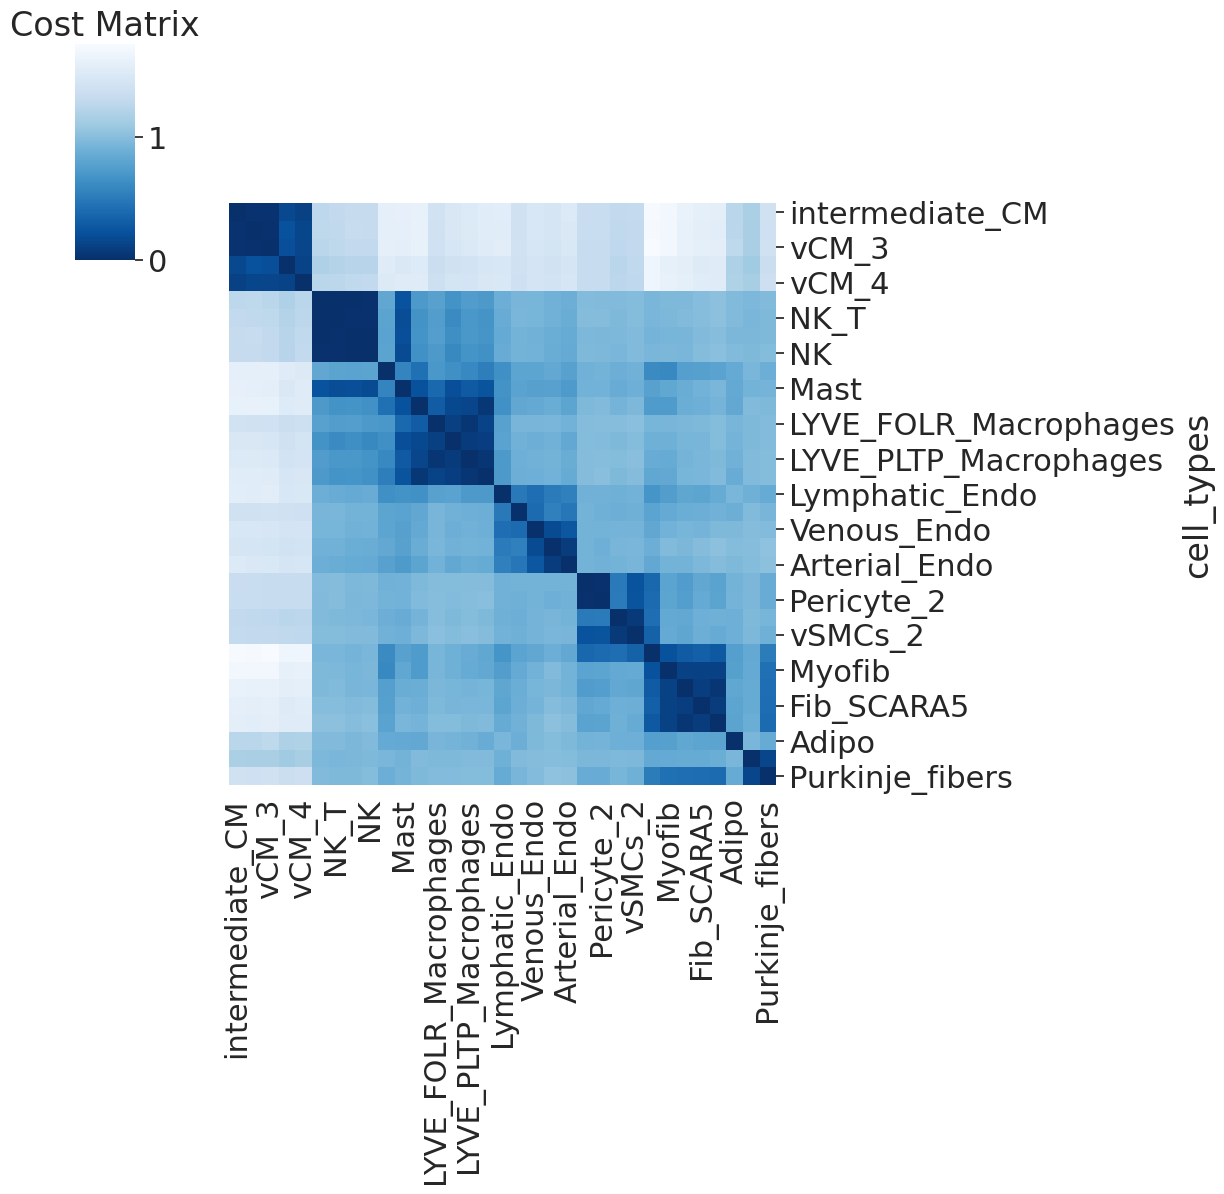

In [5]:
#the path_to_results is set automatically by PILOT with extract_data_anno_scRNA_from_h5ad funtion.
cost= cost_matrix(annot,data,path_to_results)

### Estimate the Wasserstein distance:
<div class="alert alert-block alert-info"> 
This function computes the distances among samples based on Wasserstein distance. It needs the proportions of cells for samples and also the cost between cells/clusters. The classical OT here is applied. By changing the regularized parameter (make it reg instead of unreg and also choosing a proper reg (Regularization term), you can swap it with regularized OT (sinkhorn_stabilized).    
</div>

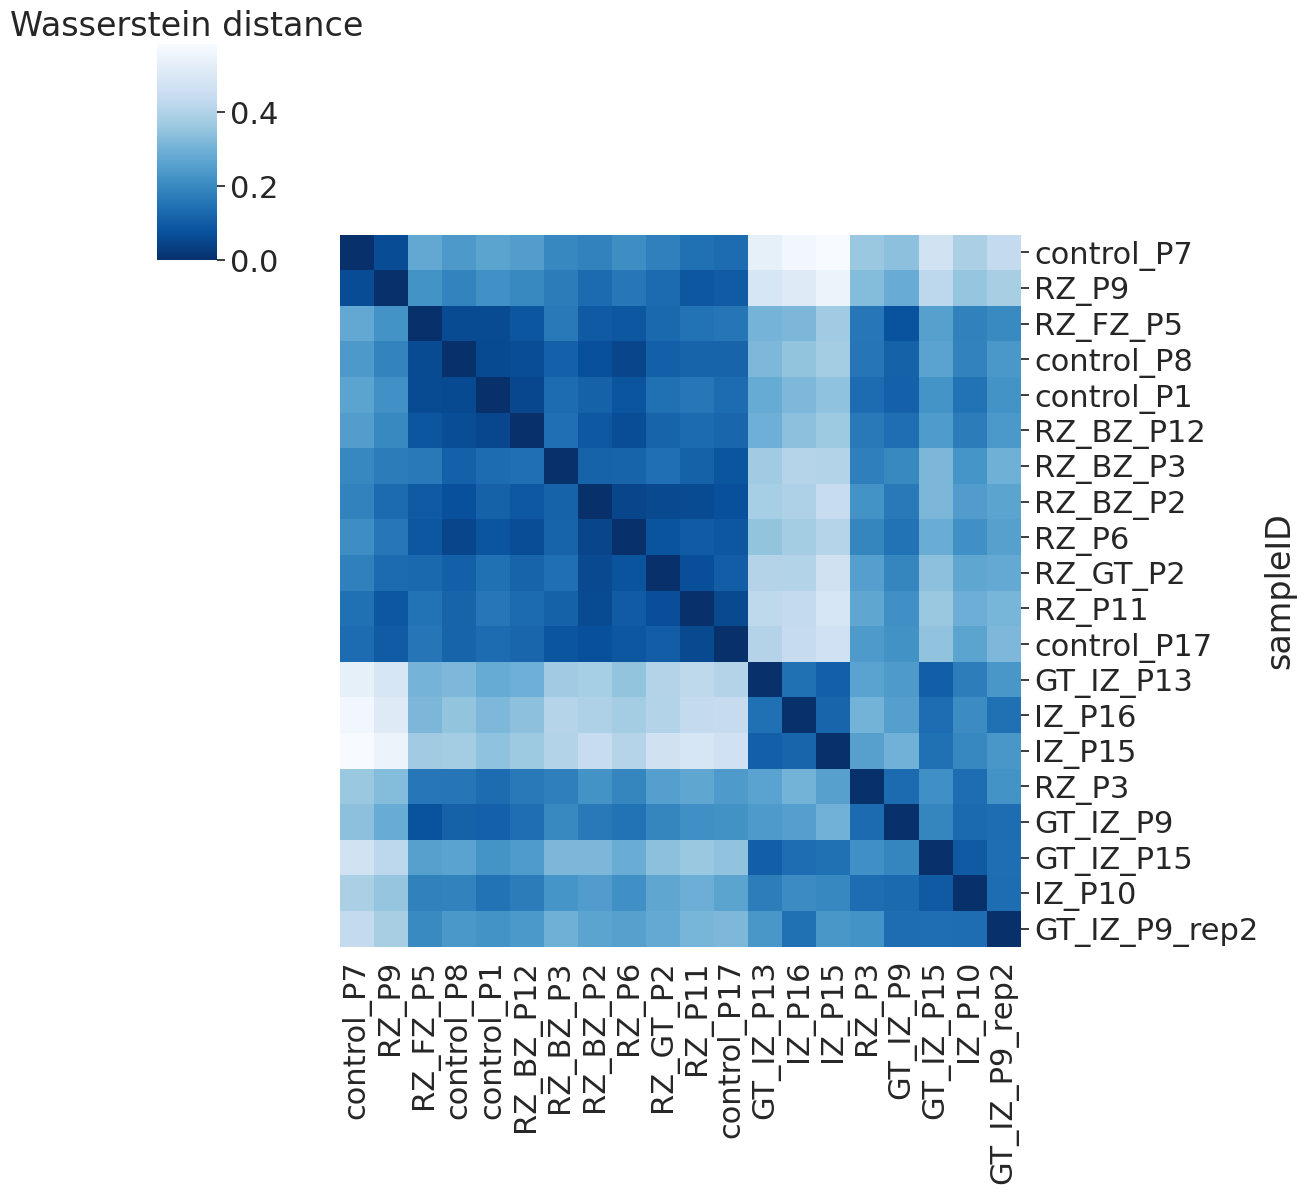

In [6]:
EMD = wasserstein_d(proportions,cost/cost.max(),path = path_to_results)

### Evaluation and Trajectory:
<div class="alert alert-block alert-info"> 
After getting the distances among samples with OT (EMD matrix), we apply the clustering method (Leiden, the number of clusters should be the exact number of the specific status) for calcualting ARI and Sil. Then the Trjectory is found based on EMD matrix.   
</div>


Cluster labels:  ['control', 'IZ']
Categories (2, object): ['IZ', 'control']
ARI:  0.9
Silhouette score:  0.7392508867168278


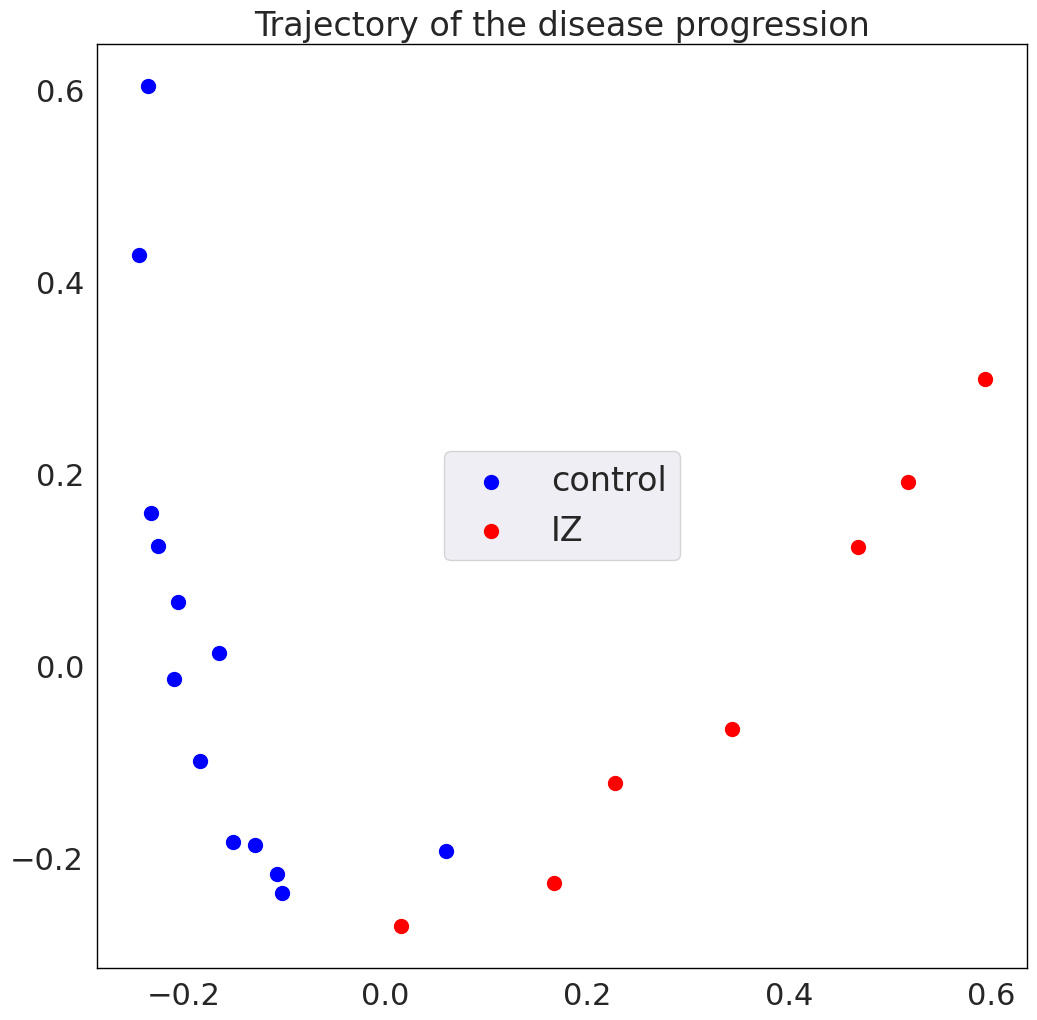

In [7]:
#Computing clusters and then ARI
predicted_labels, ARI, real_labels = Clustering(EMD/EMD.max(), annot)
#Computing Sil
Silhouette = Sil_computing(EMD/EMD.max(), real_labels)
#Drawing diffusion map
embedding_diff=trajectory(EMD/EMD.max(), predicted_labels, annot,path = path_to_results,colors=['blue','red'])


###  Fit a principal graph:
<div class="alert alert-block alert-info"> 
Drawing the backbone of the trajectory with EIPLGraph.
Here the source_node is important to start ranking samples, simply you can choose the start point from control samples.  It also allows
us to rank samples with a disease progression score t = t1, ...,tn, where tl is the ranking of the sample n
</div>


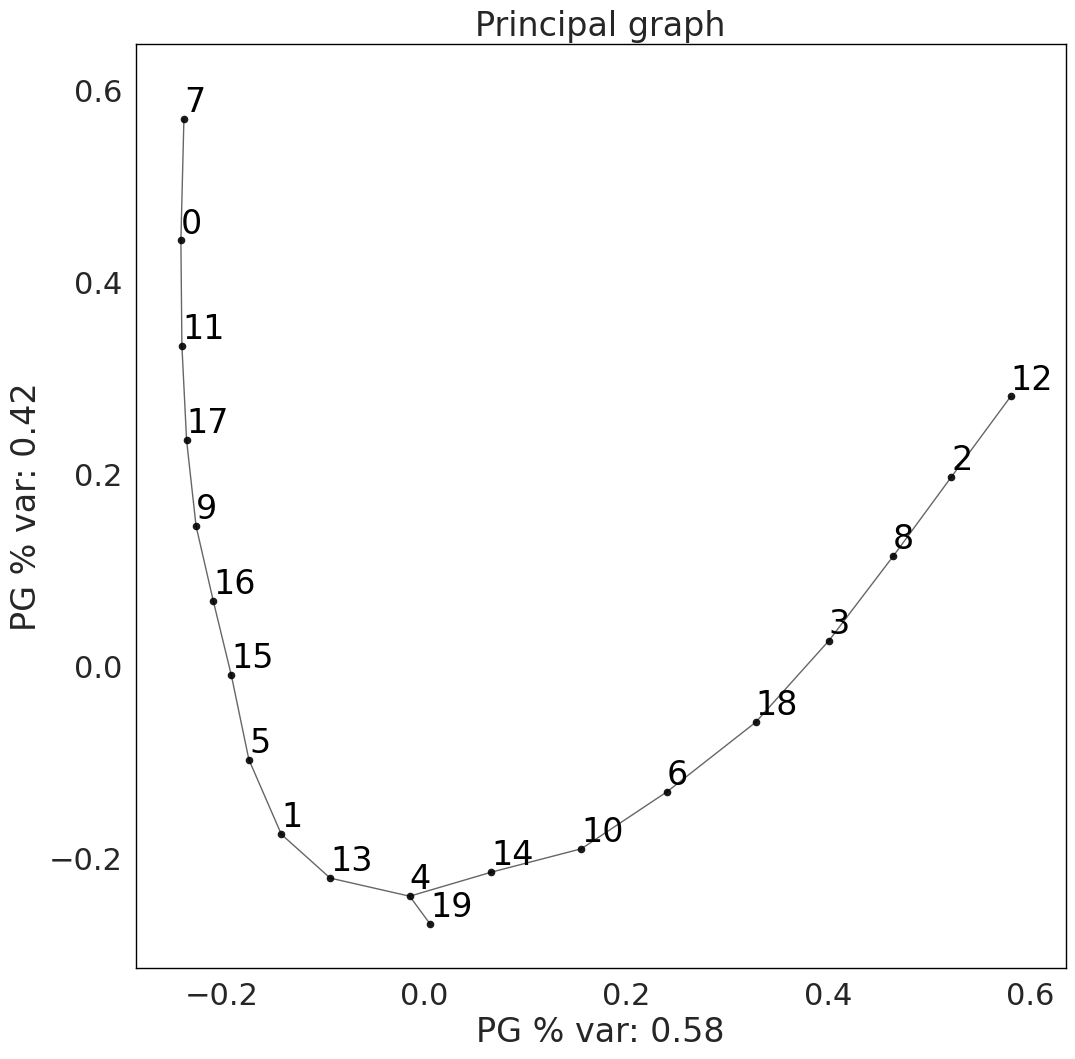

In [8]:

pseudotime=fit_pricipla_graph(embedding_diff,NumNodes=20,path=path_to_results,source_node=7,show_text=True,X_color='white')

###  Cell-type importance:
<div class="alert alert-block alert-info"> 
With the found embeddings of DM, proportion matrix, and the calculated order with EIPLGraph, we get the critical cells that are changing over the disease progression(sorted samples based on the trajectory of PILOT with EIPLGraph). You can change the p-value for making the test more significant. 
</div>

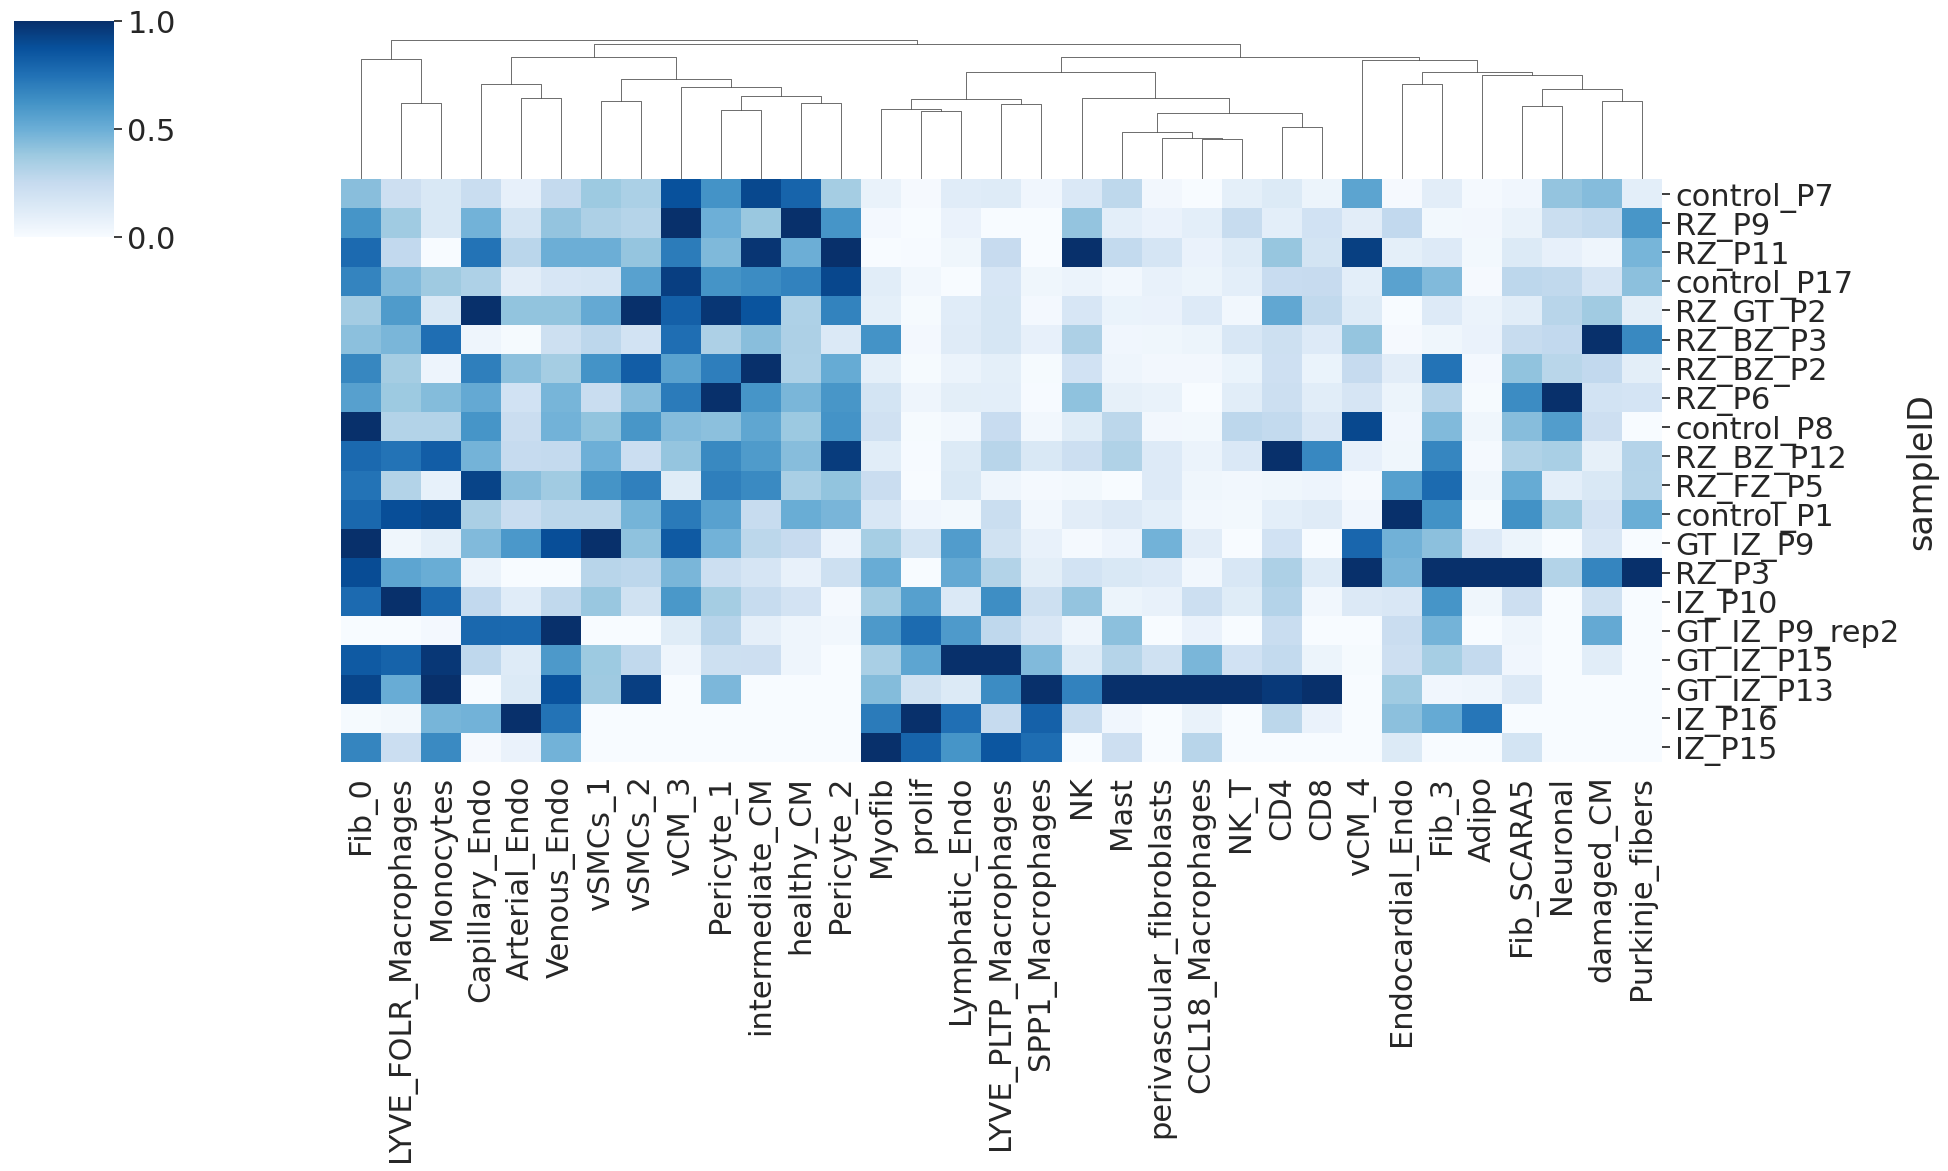

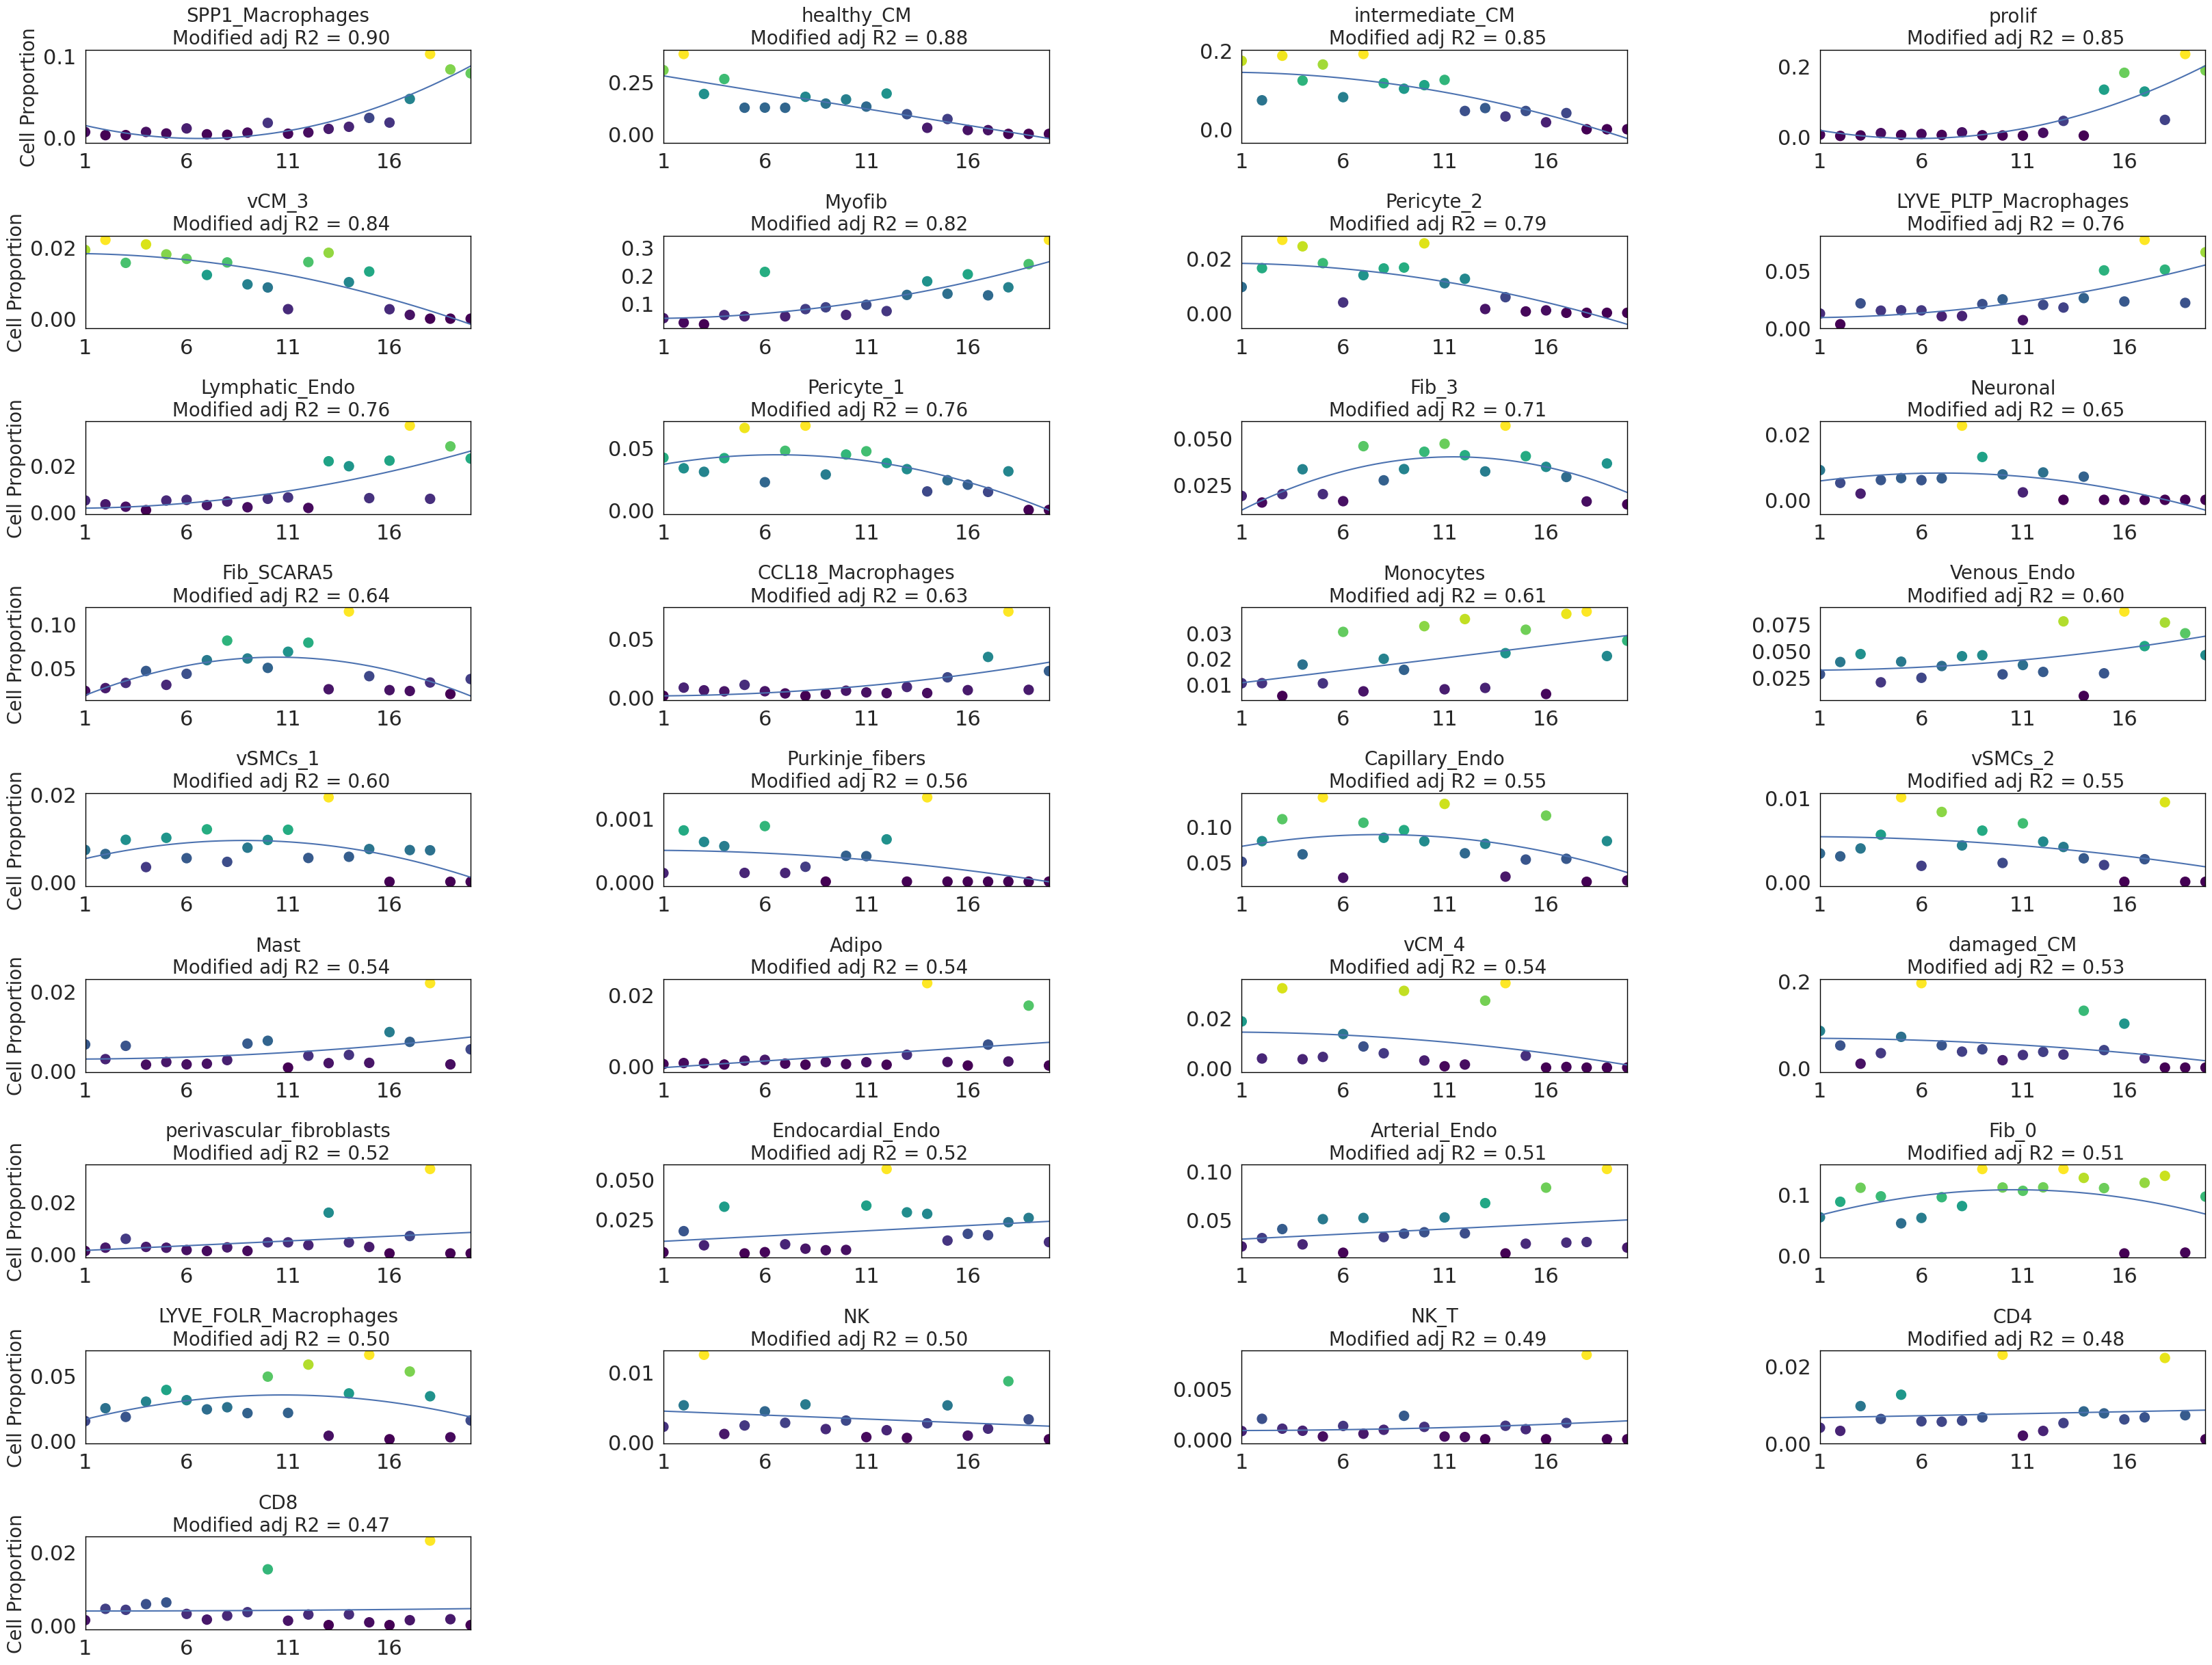

In [9]:

orders,cell_names=Cell_importance(proportions,annot,embedding_diff,real_labels,path=path_to_results,pseudotime=pseudotime,width=40,height=30,xlim=5,p_val=1,heatmap_h=20,color_back='white')

# Finding marker genes with standard approaches :

In case you are interested in ranking for the highly differential genes in each cluster with standard approaches (Wilcoxon,logreg or t-test) provided in scanpy, follow the below tutorial (for more detalis about these approches please see [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Finding-marker-genes)). 

If you want to use PILOT for finding markers please skip these steps and go to the [Applyin PILOT for finding Markers](#Applyin-PILOT-for-finding-Markers) section. 

###  Compute a ranking for the highly differential genes in each cluster.

In [6]:
sc.tl.rank_genes_groups(adata, groupby='cell_subtype', method='t-test')   

### Ploting found markers

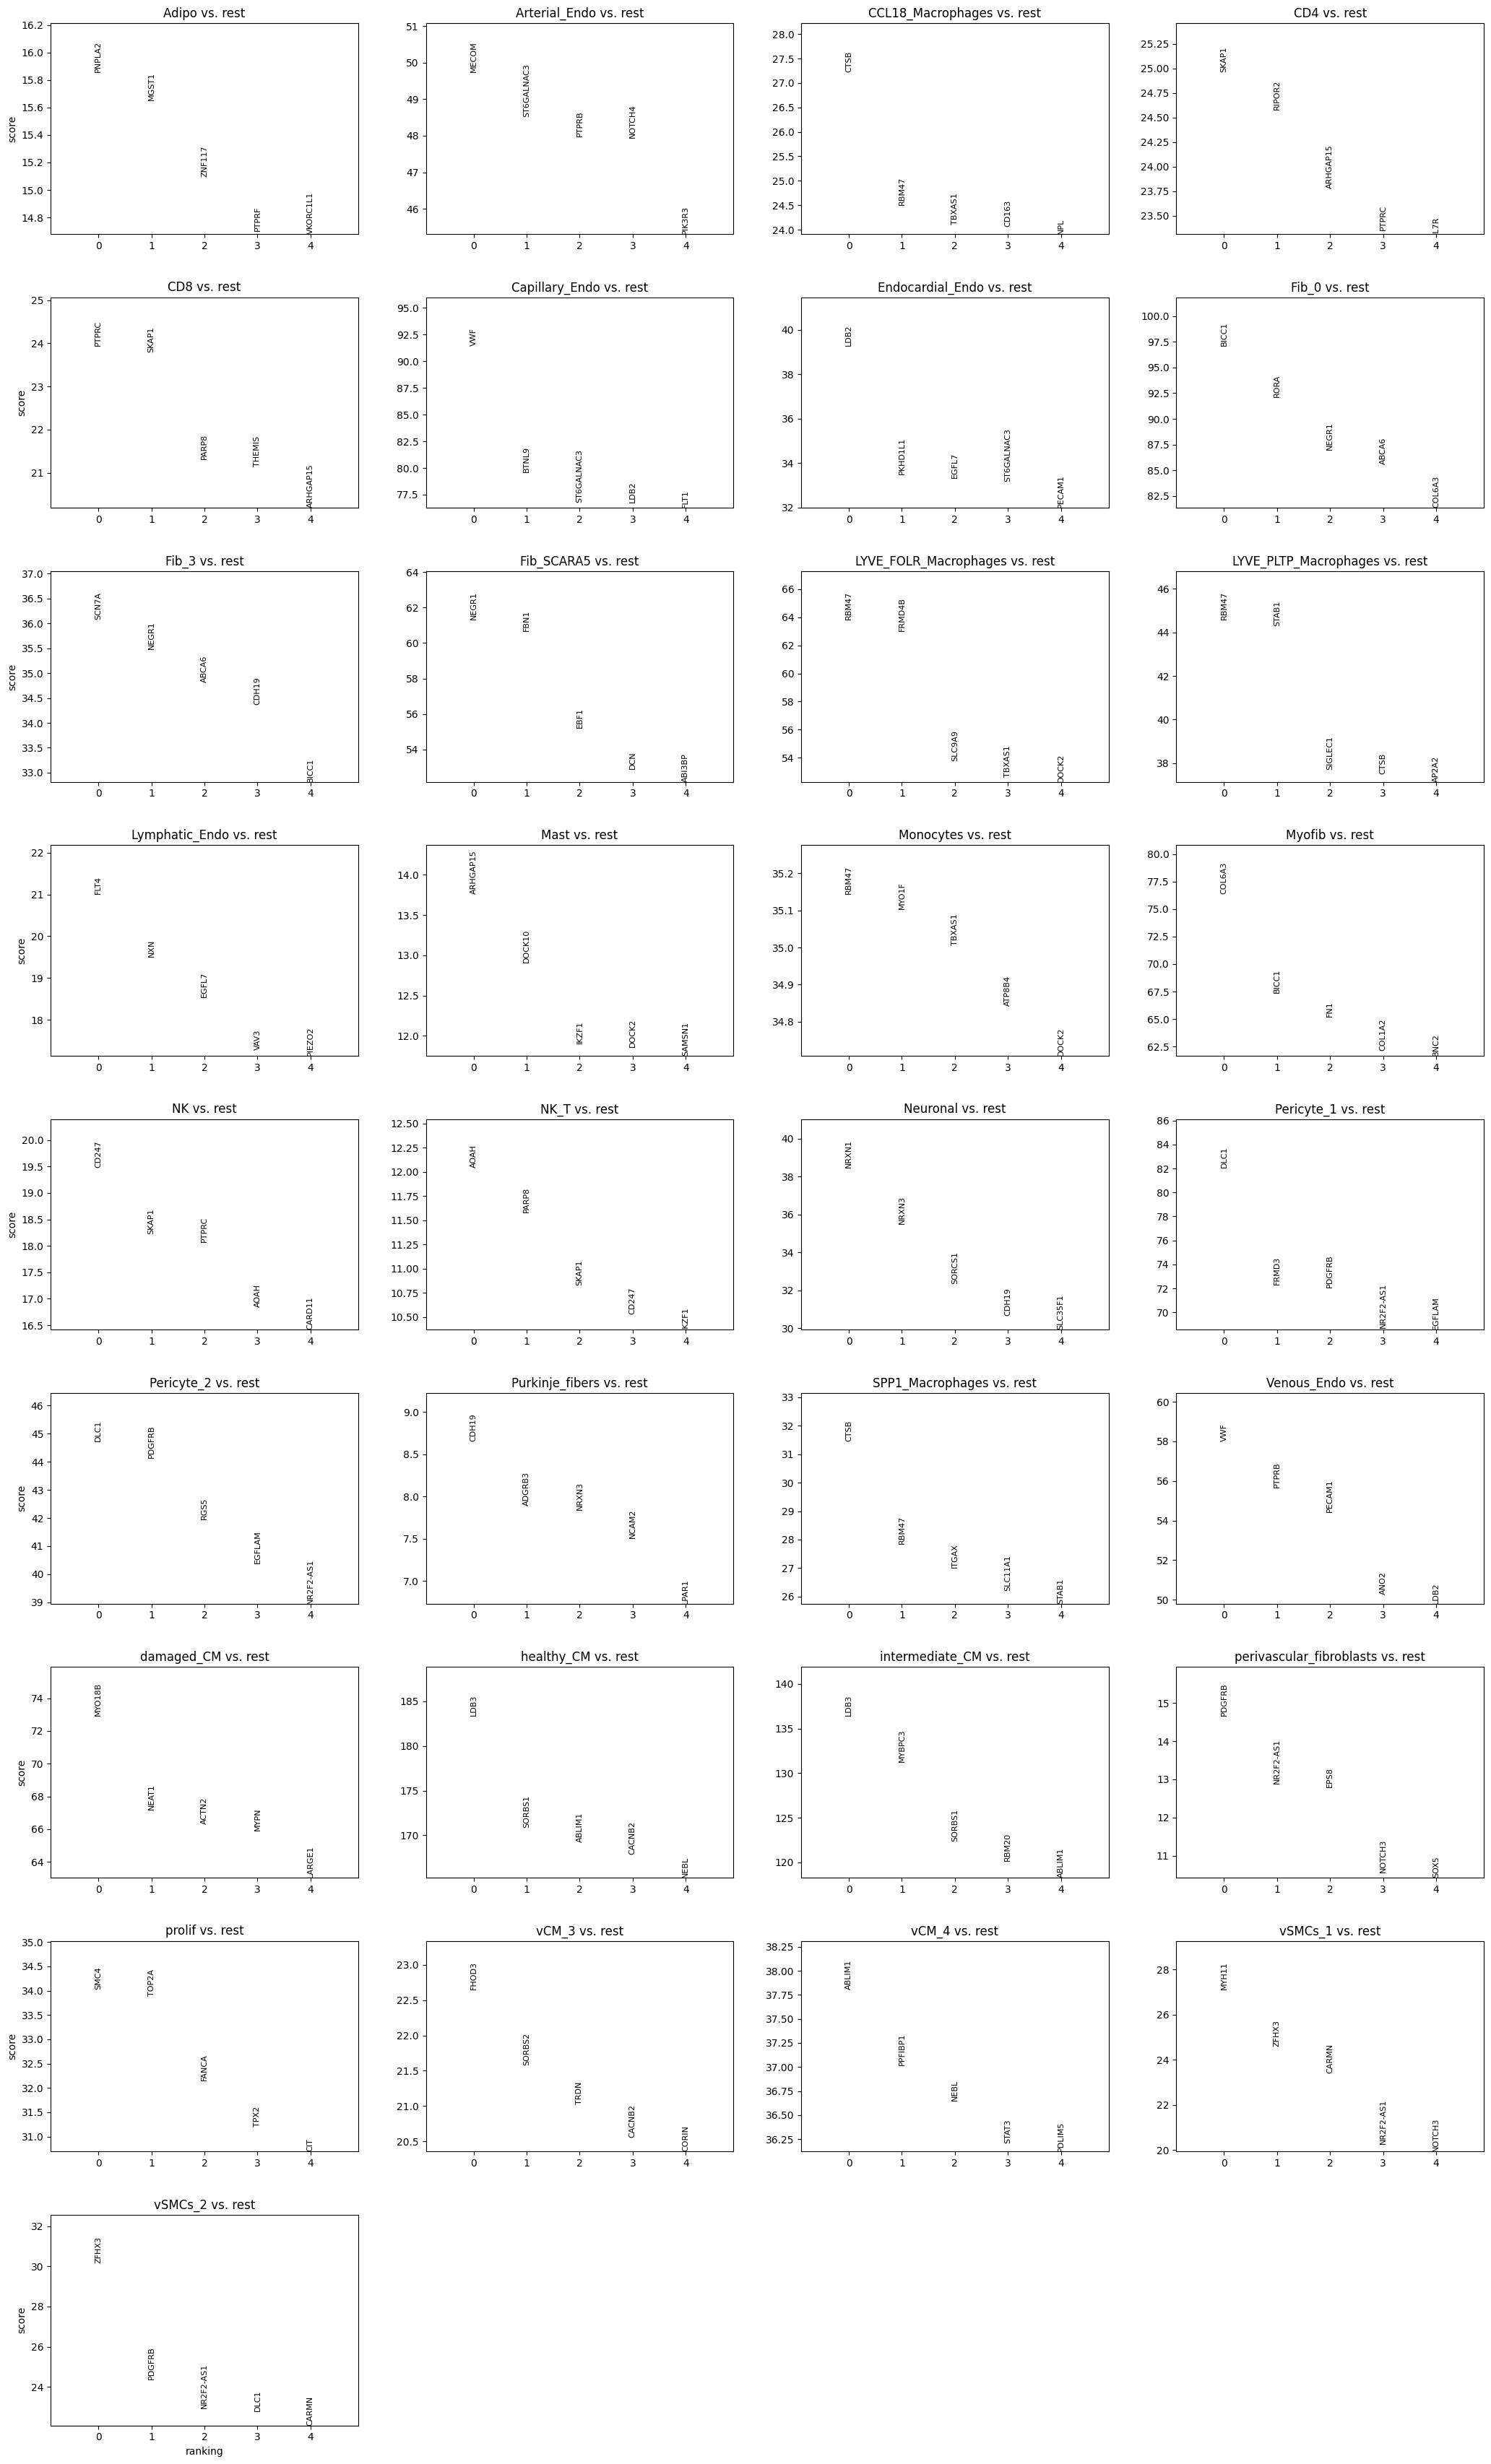

In [7]:
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

### Looking at a specific group that you are interested. For example here we consider "healthy_CM".

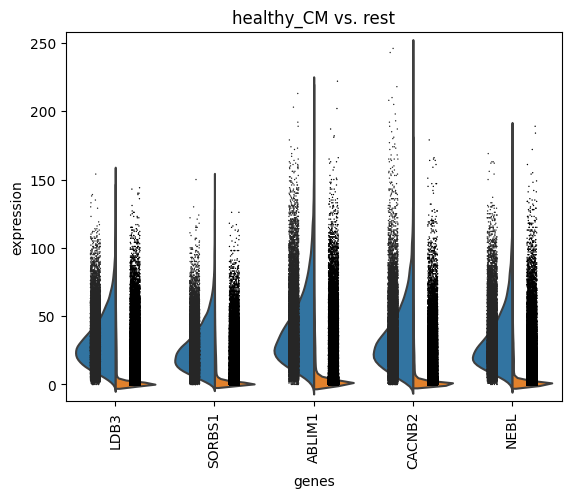

In [12]:
sc.pl.rank_genes_groups_violin(adata, groups='healthy_CM', n_genes=5)

###  Using the dotplot/violinplot for the found five first genes for "healthy _ CM" to compare their mean expressions in others.

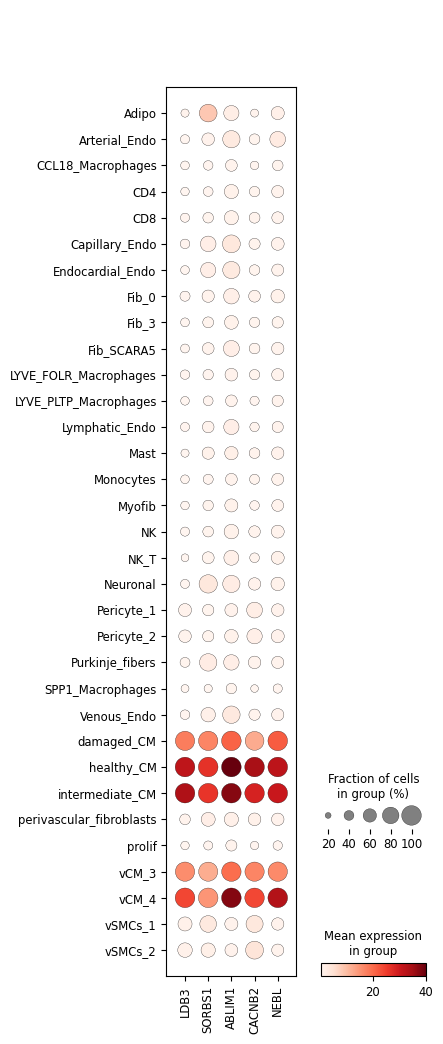

In [14]:
sc.pl.dotplot(adata, ['LDB3','SORBS1','ABLIM1','CACNB2','NEBL'], groupby='cell_subtype');

# Applyin PILOT for finding Markers

### Extract gene expressions from Original object :
<div class="alert alert-block alert-info"> 
This step extracts genes associated with each cell_type (your insterested cells) and map them with the obtained time by PILOT (based on the Trjaectory order of Samples).
    
* It uses the cell_names list from the previous step.
    
* You need to use the orinigal obejct (h5ad) to extract genes of each cell-type, we provide the "extract_cells_from_gene_expression" function that you just need to set names of columns that show cell_types/clusters and Samples/Patinets in your object and Cell_list includes list of your interested cell_types/clusters. you can use the "cell_names" list from the previous step.
    
* The function "extract_cells_from_gene_expression"  automatically creates a cells folder and put the extracted genes_expression associate with each cell and  obtained time by PILOT(orders).
</div>

In [10]:
#Takes some time to extract and save the data in cells folder.
extract_cells_from_gene_expression(adata,orders,sample_col='sampleID',col_cell='cell_subtype',cell_list=cell_names,path_results=path_to_results)

### Gene selection:
<div class="alert alert-block alert-info"> 
In this step, we find genes that are changed specifically over the disease progression (order of Trajectory from Control to IZ) per specific cell. In other words, we uncover genes with different patterns.You need to reproduce whole markers for cells by running the following code. After running the code, you can  see a folder named 'Markers' that for each cell there is a folder inside that includes 'Whole_expressions.csv'. 
Whole_expressions file covers the found genes and their statistics.    
Please be patient for this part, it takes time for whole cells.
</div>

In [11]:
#This step takes time
#Check the Results_PILOT/myocardial_infarction/Markers folder for saved results after finishing this part. 
for cell_n in cell_names:
    data =loadTarget(path_to_results+'/cells/', cell_n)
    pro=cal_proportions(data)  #Calculate the proportion of Zero for genes
    fiternames_pro=list(pro[pro['proportion']> 0.95]['Gene ID']) #Filter genes with high probability zero fraction
    data=data[data.columns[~data.columns.isin(fiternames_pro)]]
    genes_importance(pro,data,path=path_to_results,name_cell=cell_n,col='Time_score',genes_index=list(range(2, data.shape[1])),p_value=0.05,max_iter_huber=100,epsilon_huber=1.35,modify_r2=False)

Name of Cell type : SPP1_Macrophages
sparsity:0.8410225813474638
For this cell_type, p-value of  344 genes are statistically significant.
         Expression pattern  count
4            quadratic down     98
1  linear down quadratic up     94
0               linear down     84
5              quadratic up     45
2                 linear up     15
3  linear up quadratic down      8
data saved successfully
Name of Cell type : healthy_CM
sparsity:0.6932279564364608
For this cell_type, p-value of  3206 genes are statistically significant.
           Expression pattern  count
4    linear up quadratic down   1134
2    linear down quadratic up    758
0                 linear down    581
3                   linear up    347
6              quadratic down    216
7                quadratic up    164
1  linear down quadratic down      5
5      linear up quadratic up      1
data saved successfully
Name of Cell type : intermediate_CM
sparsity:0.6961095740535054
For this cell_type, p-value of  2997 ge

For this cell_type, p-value of  304 genes are statistically significant.
         Expression pattern  count
0               linear down     94
1  linear down quadratic up     72
4            quadratic down     67
5              quadratic up     46
3  linear up quadratic down     16
2                 linear up      9
data saved successfully
Name of Cell type : Mast
sparsity:0.8428424050125902
For this cell_type, p-value of  314 genes are statistically significant.
         Expression pattern  count
0               linear down     89
4            quadratic down     73
5              quadratic up     60
1  linear down quadratic up     47
2                 linear up     29
3  linear up quadratic down     16
data saved successfully
Name of Cell type : Adipo
sparsity:0.7999854983914944
For this cell_type, p-value of  198 genes are statistically significant.
         Expression pattern  count
4            quadratic down     89
3  linear up quadratic down     40
0               linear down    

### Gene Cluster Differentiation:
<div class="alert alert-block alert-info"> 
After finding genes per cell, in the next step, we use the infer_gene_cluster_differentiation function to uncover the pattern of the found genes for each cell compared to other cells. You need to set your interested cells, e.g., we use 'Myofib' and 'healthy_CM' in the following part. In other hands, we  want to see the found genes of just these two cells. You can adjust it with your interest or select whole cells.

Next, PILOT picks the genes of selected cells and then finds the pattern of each gene in a distinct cell compared to other cells. 
    
 
</div>

In [12]:
#%%% get get whole gene list needed to be compared
#In the case of being empty, it automatically considers all cells to compare with.
gene_list = []
for c in ['Myofib','healthy_CM']: #Your interested cell, this gets the genes of these cells and compares with others
    data = pd.read_csv(path_to_results + '/Markers/' + str(c) + '/Whole_expressions.csv', index_col = 0)
    specific_data = data.sort_values(['Expression pattern', 'adjusted P-value', 'R-squared'],
               ascending=[True, True, False]).groupby('Expression pattern').head(70)
    gene_list.extend(specific_data['Gene ID'].tolist())
gene_list = np.unique(gene_list) 

In [14]:
#Finding the differentiation
infer_gene_cluster_differentiation(gene_list,path_to_results = path_to_results)